In [1]:
#decompress the .bz2 file into .tar file
import sys
import os
import bz2

zipfile = bz2.BZ2File("./RML2016.10a.tar.bz2") # open the file
data = zipfile.read() # get the decompressed data

In [2]:
#write the .tar file
open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

640952320

In [3]:
#extract the .tar file
import tarfile
my_tar = tarfile.open('./RML2016.10a.tar')
my_tar.extractall('./RadioML_data') # specify which folder to extract to
my_tar.close()

In [4]:
#extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("./RadioML_data/RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [5]:
# Import all the things we need ---
%matplotlib inline
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten,LayerNormalization
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

In [6]:
# Partition the data into training and test sets of the form we can train/test on 
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
#len(train_idx)

In [7]:
#one-hot encoding the label
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [8]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [9]:
dr = 0.6 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(Flatten())
model.add(LayerNormalization(axis=1 , center=True , scale=True))
model.add(Dense(500, activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense(200, activation='relu', name="dense2"))
model.add(Dropout(dr))
model.add(Dense(40, activation='relu', name="dense3"))
model.add(Dropout(dr))
model.add(Dense(11, activation='softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 2, 128)         0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 layer_normalization (LayerN  (None, 256)              512       
 ormalization)                                                   
                                                                 
 dense1 (Dense)              (None, 500)               128500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense2 (Dense)              (None, 200)               100200    
                                                        

In [10]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 5000  # training batch size

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'ANN_0.6_woPCA.wts.h5'
import time
t_0=time.time()

history = model.fit(X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, y_valid),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
delta_t=time.time()-t_0
print(delta_t)
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
18/18 - 5s - loss: 2.3829 - accuracy: 0.1142 - val_loss: 2.2883 - val_accuracy: 0.1510 - 5s/epoch - 281ms/step
Epoch 2/100
18/18 - 1s - loss: 2.3113 - accuracy: 0.1380 - val_loss: 2.2526 - val_accuracy: 0.1596 - 1s/epoch - 77ms/step
Epoch 3/100
18/18 - 1s - loss: 2.2832 - accuracy: 0.1404 - val_loss: 2.2340 - val_accuracy: 0.1758 - 1s/epoch - 76ms/step
Epoch 4/100
18/18 - 1s - loss: 2.2588 - accuracy: 0.1450 - val_loss: 2.2097 - val_accuracy: 0.1836 - 1s/epoch - 76ms/step
Epoch 5/100
18/18 - 1s - loss: 2.2321 - accuracy: 0.1499 - val_loss: 2.1720 - val_accuracy: 0.1930 - 1s/epoch - 81ms/step
Epoch 6/100
18/18 - 1s - loss: 2.1968 - accuracy: 0.1634 - val_loss: 2.1168 - val_accuracy: 0.2415 - 1s/epoch - 78ms/step
Epoch 7/100
18/18 - 1s - loss: 2.1497 - accuracy: 0.1828 - val_loss: 2.0467 - val_accuracy: 0.2694 - 1s/epoch - 76ms/step
Epoch 8/100
18/18 - 1s - loss: 2.0955 - accuracy: 0.2064 - val_loss: 1.9756 - val_accuracy: 0.2743 - 1s/epoch - 77ms/step
Epoch 9/100
18/18 - 1s 

Epoch 68/100
18/18 - 1s - loss: 1.5964 - accuracy: 0.3818 - val_loss: 1.6851 - val_accuracy: 0.3675 - 1s/epoch - 82ms/step
Epoch 69/100
18/18 - 2s - loss: 1.5946 - accuracy: 0.3847 - val_loss: 1.6854 - val_accuracy: 0.3681 - 2s/epoch - 84ms/step
101.46208119392395


In [13]:
# Show simple version of performance
score1 = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
score2 = model.evaluate(X_valid, y_valid, verbose=0, batch_size=batch_size)
score3 = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
print(score1)
print(score2)
print(score3)

[1.4511255025863647, 0.4406931698322296]
[1.6807080507278442, 0.3709999918937683]
[1.6852688789367676, 0.37070000171661377]


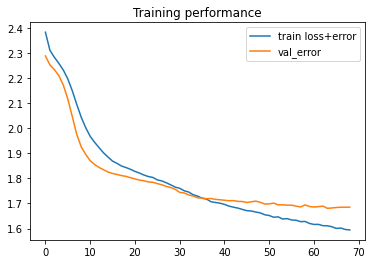

In [14]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [15]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

22/22 [==============================] - 1s 23ms/step


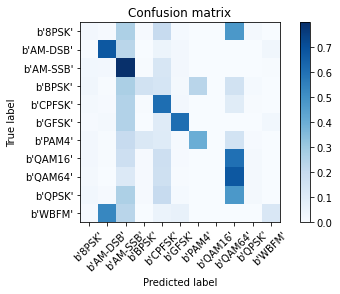

In [16]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

174/174 [==============================] - 0s 1ms/step
Overall Accuracy:  0.09680316091954023 for SNR b'-20'
172/172 [==============================] - 0s 1ms/step
Overall Accuracy:  0.09892316116079576 for SNR b'-18'
174/174 [==============================] - 0s 1ms/step
Overall Accuracy:  0.0997115037865128 for SNR b'-16'
171/171 [==============================] - 0s 1ms/step
Overall Accuracy:  0.10296269202633504 for SNR b'-14'
175/175 [==============================] - 0s 1ms/step
Overall Accuracy:  0.13011617515638962 for SNR b'-12'
170/170 [==============================] - 0s 1ms/step
Overall Accuracy:  0.20930660290601436 for SNR b'-10'
169/169 [==============================] - 0s 1ms/step
Overall Accuracy:  0.2583210059171598 for SNR b'-8'
172/172 [==============================] - 0s 1ms/step
Overall Accuracy:  0.3858943906449845 for SNR b'-6'
175/175 [==============================] - 0s 1ms/step
Overall Accuracy:  0.49551810684833275 for SNR b'-4'
173/173 [================

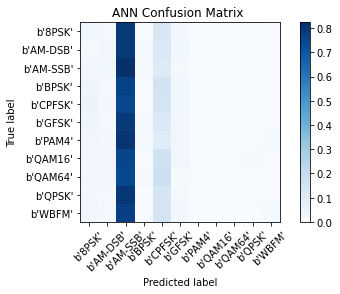

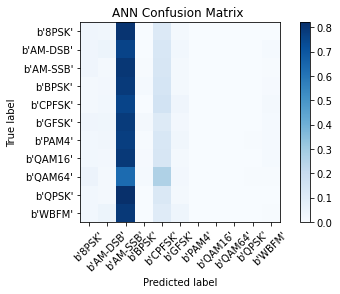

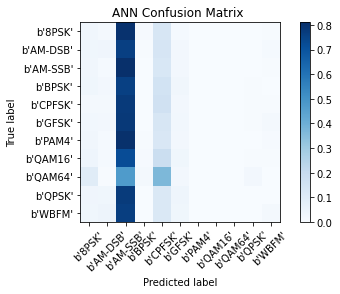

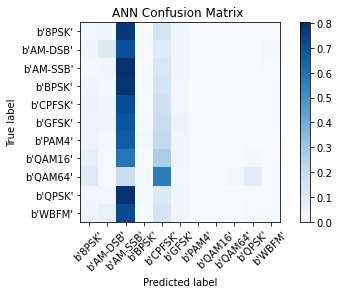

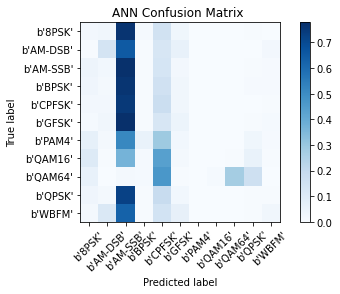

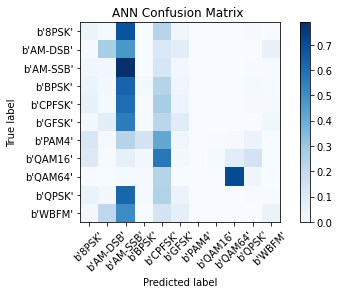

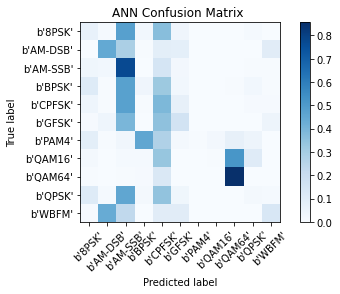

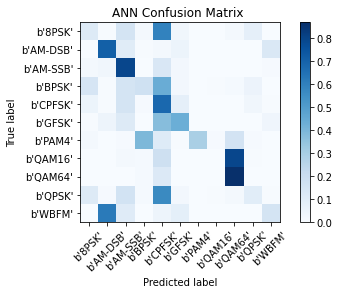

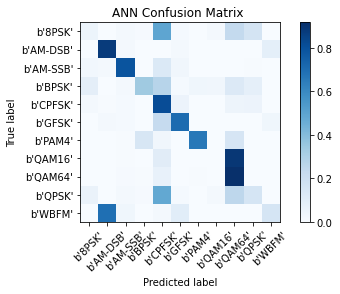

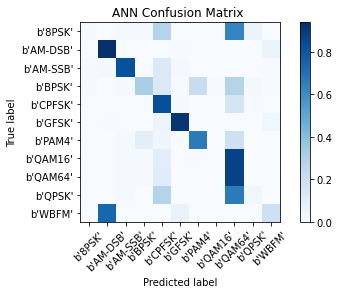

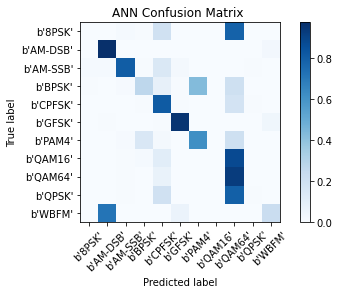

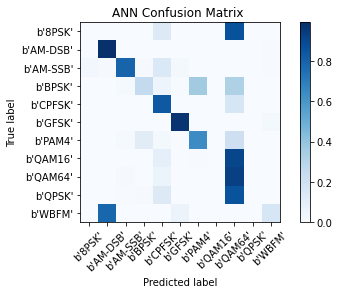

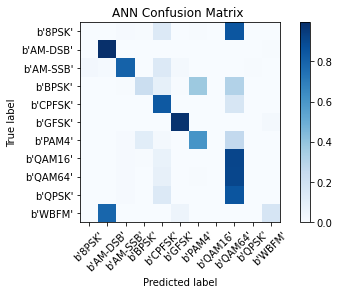

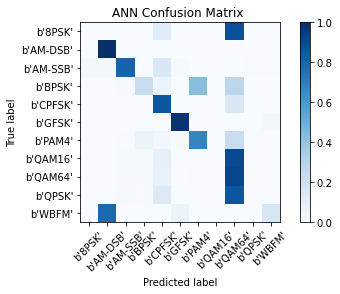

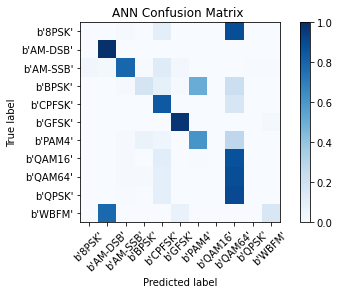

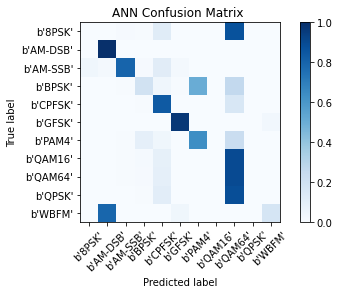

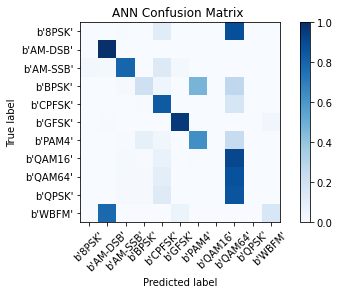

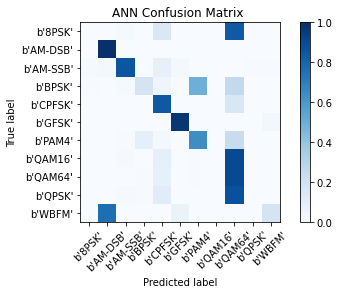

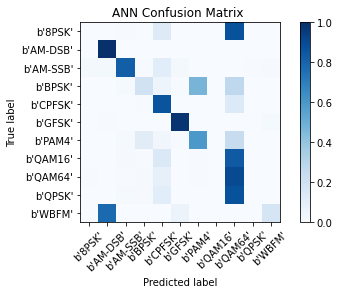

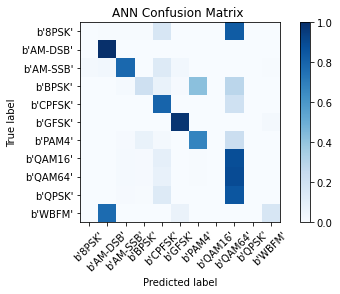

In [17]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])

#print(snr_label_array)
y_test_snr=snr_array[test_idx]



for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ANN Confusion Matrix "%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

In [18]:
print(acc_array)

[0.09680316091954023, 0.09892316116079576, 0.0997115037865128, 0.10296269202633504, 0.13011617515638962, 0.20930660290601436, 0.2583210059171598, 0.3858943906449845, 0.49551810684833275, 0.5085330428467684, 0.5102903344358691, 0.5119738751814223, 0.4962488563586459, 0.5107319757842598, 0.4967637540453074, 0.4977754048763125, 0.4902603313307846, 0.5082802547770701, 0.506472196900638, 0.5024002954209749]


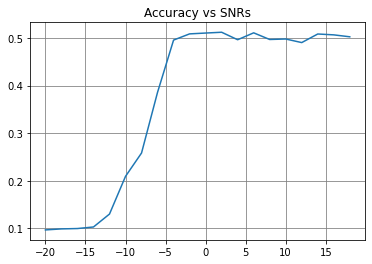

In [19]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.grid(linestyle="-", color='grey')
plt.plot(np.arange(-20,20,2), acc_array)

In [ ]:
bs_256  = [0.09746839080459771, 0.09682807081584231, 0.09890840245221781, 0.10068251645940014, 0.1264307417336908, 0.19962663233400773, 0.2441937869822485, 0.39454595285949206, 0.4751165292219433, 0.535439360929557, 0.531646453509739, 0.5410087082728593, 0.5001829826166514, 0.5117244542285819, 0.5832434376123696, 0.5837337604555971, 0.5803750227562352, 0.5941765241128298, 0.5930720145852324, 0.5932422451994092];
bs_1024 = [0.09764798850574713, 0.09591549552838110, 0.09764623151821132, 0.09876810534016094, 0.1291394101876675, 0.22445650174728711, 0.28653846153846156, 0.40479261830805776, 0.5055934026532808, 0.5125635439360929, 0.5088607129731717, 0.5143396226415094, 0.4769441903019213, 0.5053971748303064, 0.5685005393743258, 0.5680726107848372, 0.5647187329328236, 0.5805277525022748, 0.570464904284412, 0.577917282127031];
#bs_5000= [0.09375            , 0.10074831173571820, 0.09826902271907681, 0.10515727871250914, 0.12672028596961574, 0.19385690638219608, 0.308801775147929, 0.4735976612461173, 0.5937612047328792, 0.6309005083514887, 0.6054759279676589, 0.6081277213352685, 0.5919487648673376, 0.5934690882406898, 0.5807263574253866, 0.588716853532657, 0.5841980702712544, 0.5954504094631483, 0.5874202370100273, 0.5941654357459379];
        = [0.09680316091954023, 0.09892316116079576, 0.0997115037865128, 0.10296269202633504, 0.13011617515638962, 0.20930660290601436, 0.2583210059171598, 0.3858943906449845, 0.49551810684833275, 0.5085330428467684, 0.5102903344358691, 0.5119738751814223, 0.4962488563586459, 0.5107319757842598, 0.4967637540453074, 0.4977754048763125, 0.4902603313307846, 0.5082802547770701, 0.506472196900638, 0.5024002954209749]